## **Import Libraries**

In [27]:
import re 
from typing import List, Dict, Optional
import numpy as np
from PIL import Image
import pytesseract
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import requests
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import json

## **Bank Classification**


In [28]:
def classify_bank(image_path: str, model, class_indices) -> str:
    if model is None:
        print("Bank classfication model not loaded. Returning 'Unknown'.")
        return "Unknown"
    
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize((224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions[0])
        predicted_bank = class_indices[predicted_class_index]
        confidence = predictions[0][predicted_class_index]
        
        print(f"Predicted bank: {predicted_bank} with confidence: {confidence:.2f}")
        return predicted_bank
    except Exception as e:
        print(f"Error during bank classification: {e}")
        return "Unknown"

## **Image preprocessing**

In [29]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply slight Gaussian Blur to remove noise
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    
    mean_val = np.mean(blurred)
    # Adaptive thresholding
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
    # If background is dark, invert the image
    if mean_val < 127:
        thresh = cv2.bitwise_not(thresh)
    
    return thresh

def preprocess_image_advanced(image_path, debug=False):
    """
    Preprocess an image for OCR, robust to both dark and light backgrounds.
    Crops to the transaction region, resizes, enhances, and inverts if needed.
    Optionally saves intermediate images for debugging.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image at {image_path}")
    # Remove cropping to preserve all transaction data
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, None, fx=3.0, fy=3.0, interpolation=cv2.INTER_LANCZOS4)
    mean_val = np.mean(gray)
    if mean_val < 127:
        gray = cv2.bitwise_not(gray)
    alpha = 0.9
    beta = 60
    adjusted = cv2.convertScaleAbs(gray, alpha=alpha, beta=beta)
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpened = cv2.filter2D(adjusted, -1, kernel)
    normalized = cv2.normalize(sharpened, None, 0, 255, cv2.NORM_MINMAX)
    # if mean_val < 127:
    #     result = cv2.adaptiveThreshold(normalized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
    # else:
    result = normalized
    if debug:
        import os
        debug_dir = os.path.join(os.path.dirname(image_path), 'debug_preprocess')
        os.makedirs(debug_dir, exist_ok=True)
        cv2.imwrite(os.path.join(debug_dir, '01_gray.png'), gray)
        cv2.imwrite(os.path.join(debug_dir, '02_adjusted.png'), adjusted)
        cv2.imwrite(os.path.join(debug_dir, '03_sharpened.png'), sharpened)
        cv2.imwrite(os.path.join(debug_dir, '04_normalized.png'), normalized)
    return result

## **Data Extraction Function**

In [30]:
def extract_data_aba(image):
    """Extract transaction details from a preprocessed ABA Bank receipt image."""
    # OCR configuration
    config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz:,.|() '
    
    try:
        # Extract text using OCR
        text = pytesseract.image_to_string(image, config=config).strip()

        # Regex patterns
        patterns = {
            "transaction_id": r":\s*Trx\. ID[:\s]*(\d+)",  
            "amount": r"([\d.]+)\s*(USD|KHR)",  
            "date": r"Transaction\s* date[:\s]*([A-Za-z]+\s*\d{1,2},\s*\d{4}\s*\|\s*\d{1,2}:\d{2}[a-zA-Z]*)",  
            "paid_from": r"Paid\s*from[:\s]*([^.]+)\.\s*\(([\d\s]+)\)",  
        }

        data = {}
        for key, pattern in patterns.items():
            match = re.search(pattern, text, re.IGNORECASE)
            if match:  
                if key == "amount":
                    amount_str = match.group(1)
                    currency = match.group(2)
                    data[key] = f"{float(amount_str)} {currency}"
                    data["amount"] = float(amount_str)
                elif key == "paid_from":
                    data[key] = f"{match.group(1).strip()} ({match.group(2).strip()})"
                else:
                    data[key] = match.group(1).strip()
            else:
                 
                data[key] = "None" if key != "amount" else 0.0

        return data
    except Exception as e:
        print(f"Error in extract_data_aba: {e}")
        return {
            "transaction_id": "None",
            "amount": 0.0,
            "date": "None",
            "paid_from": "None"
        }

## **Testing Function**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted bank: ABA Bank with confidence: 1.00


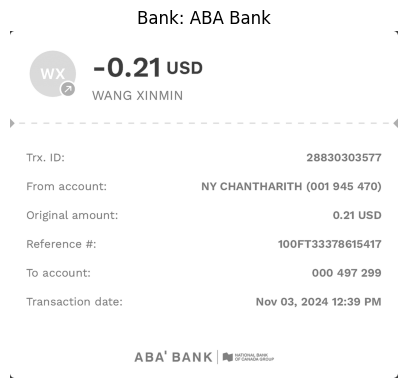

Extracted Transaction Data:
{
  "transaction_id": "None",
  "amount": 0.21,
  "date": "None",
  "paid_from": "None"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Predicted bank: ABA Bank with confidence: 1.00


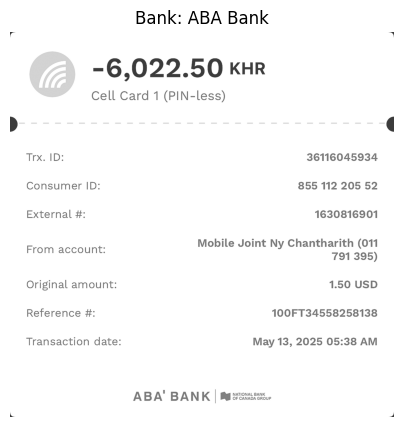

Extracted Transaction Data:
{
  "transaction_id": "None",
  "amount": 22.5,
  "date": "None",
  "paid_from": "None"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted bank: ABA Bank with confidence: 1.00


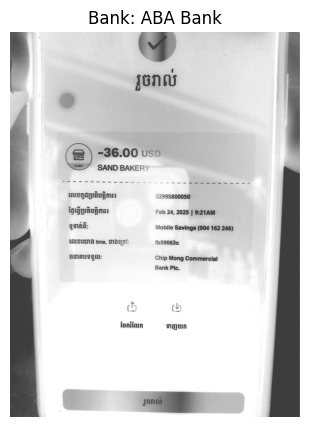

Extracted Transaction Data:
{
  "transaction_id": "None",
  "amount": 36.0,
  "date": "None",
  "paid_from": "None"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Predicted bank: ABA Bank with confidence: 1.00


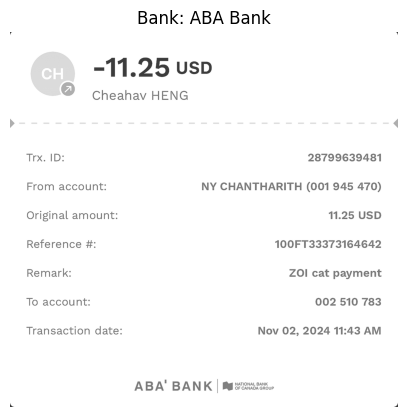

Extracted Transaction Data:
{
  "transaction_id": "None",
  "amount": 11.25,
  "date": "None",
  "paid_from": "None"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Predicted bank: ABA Bank with confidence: 1.00


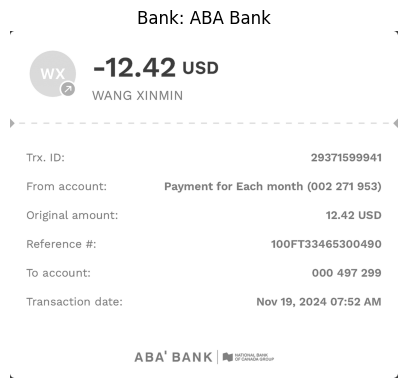

Extracted Transaction Data:
{
  "transaction_id": "None",
  "amount": 12.42,
  "date": "None",
  "paid_from": "None"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predicted bank: ABA Bank with confidence: 0.99


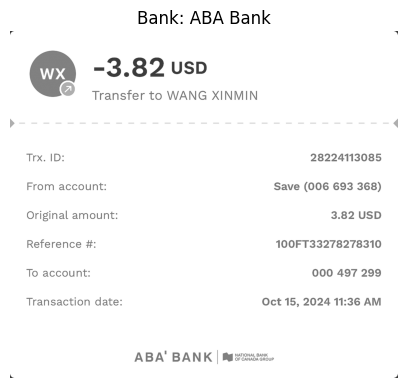

Extracted Transaction Data:
{
  "transaction_id": "None",
  "amount": 3.82,
  "date": "None",
  "paid_from": "None"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted bank: ABA Bank with confidence: 1.00


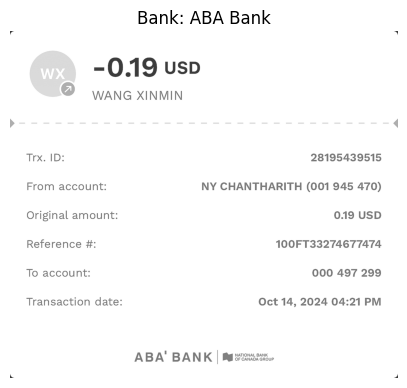

Extracted Transaction Data:
{
  "transaction_id": "None",
  "amount": 0.19,
  "date": "None",
  "paid_from": "None"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predicted bank: ABA Bank with confidence: 1.00


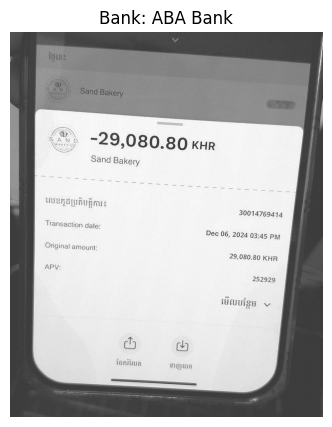

Extracted Transaction Data:
{
  "transaction_id": "None",
  "amount": 80.0,
  "date": "None",
  "paid_from": "None"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted bank: ABA Bank with confidence: 0.99


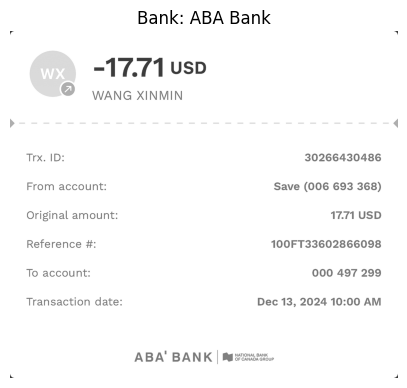

Extracted Transaction Data:
{
  "transaction_id": "None",
  "amount": 17.71,
  "date": "None",
  "paid_from": "None"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Predicted bank: ABA Bank with confidence: 1.00


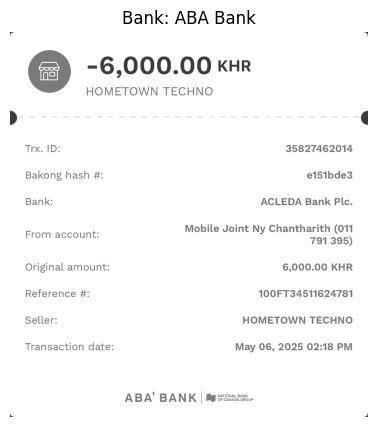

Extracted Transaction Data:
{
  "transaction_id": "None",
  "amount": 0.0,
  "date": "None",
  "paid_from": "None"
}
Total amount: 184.1


In [31]:
model_path = "../src/backend/models/bank_classification.h5"
model = load_model(model_path)

CLASS_INDEXES = ["ABA Bank", "ACLIDA Bank", "Other"]

folder_path = "../data/raw/Test/"

# Get all image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.png'))]

amount = []

for i, image_file in enumerate(image_files):
    image_path = os.path.join(folder_path, image_file)
    
    classified_image = classify_bank(image_path, model, CLASS_INDEXES)
    
    preprocessed_image = preprocess_image_advanced(image_path)
    if preprocessed_image is None:
        print(f"Skipping {image_file} due to preprocessing error.")
        continue
    
    # Extract data if the bank is classified as "ABA Bank"
    if classified_image == "ABA Bank":
        extracted_data = extract_data_aba(preprocessed_image)
    else:
        extracted_data = {
            "transaction_id": "None",
            "amount": 0.0,
            "date": "None"
        }
    
    # Display the preprocessed image
    plt.figure(figsize=(5, 5))
    plt.imshow(preprocessed_image, cmap='gray')
    plt.title(f"Bank: {classified_image}")
    plt.axis('off')
    plt.show()
    
    print(f"Extracted Transaction Data:\n{json.dumps(extracted_data, indent=2)}")
    
    amount.append(extracted_data['amount'])

print(f"Total amount: {sum(amount)}")

## **Clean Extracted Data Function**

In [32]:
def clean_extracted_data(extracted_data_list):
    
    cleaned_data = []
    total_amount = 0.0

    for data in extracted_data_list:
        # Ensure all keys are present
        transaction_id = data.get("transaction_id", "None")
        amount = data.get("amount", 0.0)
        date = data.get("date", "None")
        paid_from = data.get("paid_from", "None")

        # Validate and clean the amount
        try:
            amount = float(amount) if isinstance(amount, (int, float, str)) and amount != "None" else 0.0
        except ValueError:
            amount = 0.0

        # Add to total amount if valid
        if amount > 0:
            total_amount += amount

        # Append cleaned data
        cleaned_data.append({
            "transaction_id": transaction_id,
            "amount": amount,
            "date": date,
            "paid_from": paid_from
        })

    # Summary
    summary = {
        "total_amount": total_amount,
        "valid_transactions": len([d for d in cleaned_data if d["amount"] > 0]),
        "cleaned_data": cleaned_data
    }

    return summary

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted bank: ABA Bank with confidence: 1.00


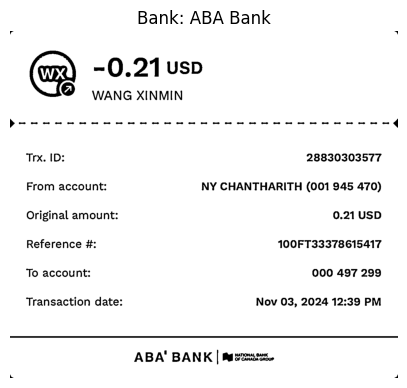

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted bank: ABA Bank with confidence: 1.00


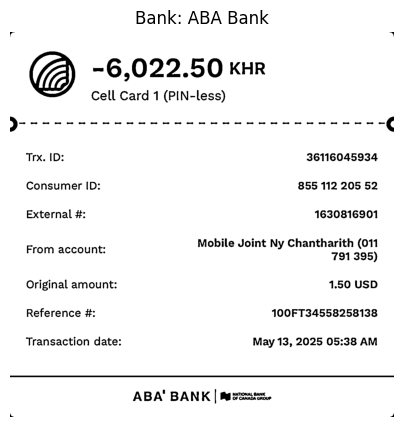

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted bank: ABA Bank with confidence: 1.00
Error in extract_data_aba: could not convert string to float: '36.00.'


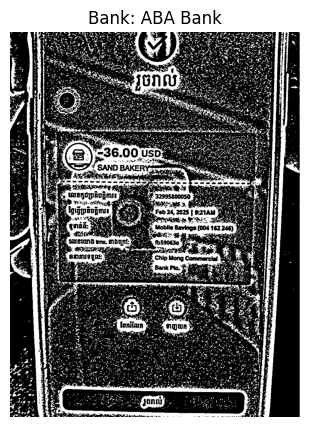

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted bank: ABA Bank with confidence: 1.00


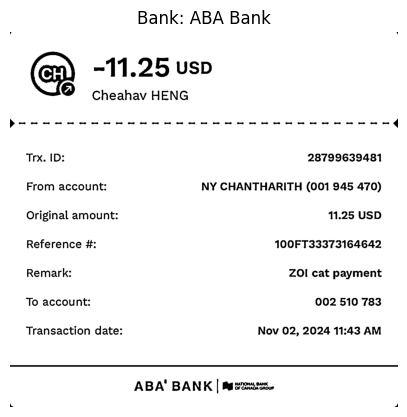

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Predicted bank: ABA Bank with confidence: 1.00


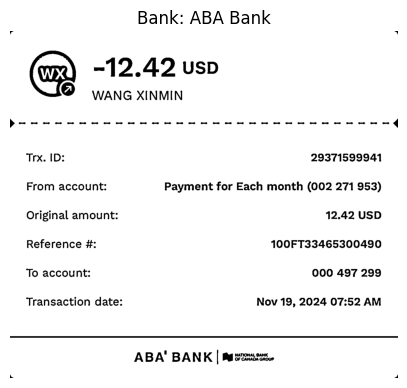

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted bank: ABA Bank with confidence: 0.99


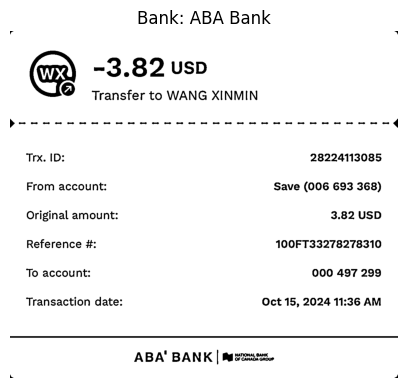

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted bank: ABA Bank with confidence: 1.00


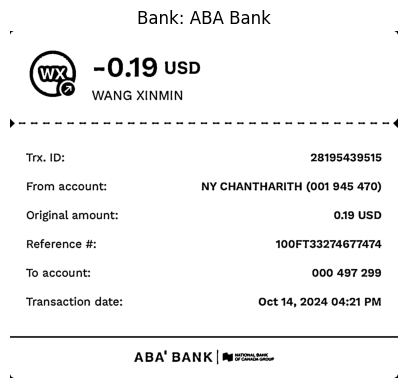

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Predicted bank: ABA Bank with confidence: 1.00


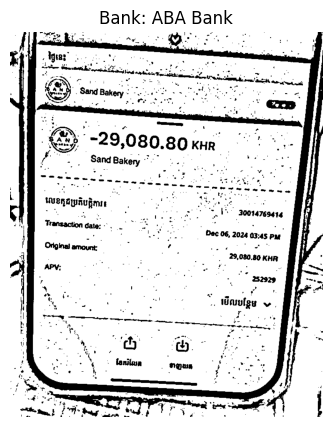

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted bank: ABA Bank with confidence: 0.99


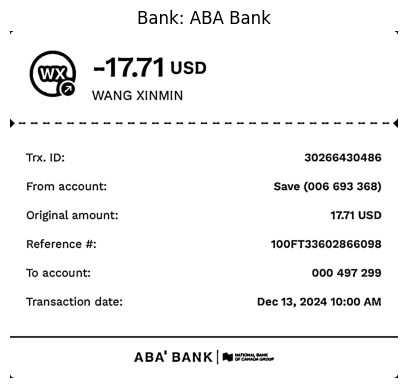

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted bank: ABA Bank with confidence: 1.00


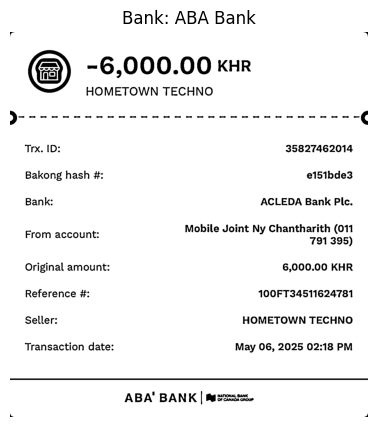

Cleaned Data:
[
  {
    "transaction_id": "None",
    "amount": 0.21,
    "date": "None",
    "paid_from": "None"
  },
  {
    "transaction_id": "None",
    "amount": 22.5,
    "date": "None",
    "paid_from": "None"
  },
  {
    "transaction_id": "None",
    "amount": 0.0,
    "date": "None",
    "paid_from": "None"
  },
  {
    "transaction_id": "None",
    "amount": 11.25,
    "date": "None",
    "paid_from": "None"
  },
  {
    "transaction_id": "None",
    "amount": 12.42,
    "date": "None",
    "paid_from": "None"
  },
  {
    "transaction_id": "None",
    "amount": 3.82,
    "date": "None",
    "paid_from": "None"
  },
  {
    "transaction_id": "None",
    "amount": 0.19,
    "date": "None",
    "paid_from": "None"
  },
  {
    "transaction_id": "None",
    "amount": 80.8,
    "date": "None",
    "paid_from": "None"
  },
  {
    "transaction_id": "None",
    "amount": 17.71,
    "date": "None",
    "paid_from": "None"
  },
  {
    "transaction_id": "None",
    "amount": 0.0,
  

In [33]:
# List to store all extracted data
extracted_data_list = []

for i, image_file in enumerate(image_files):
    image_path = os.path.join(folder_path, image_file)
    
    classified_image = classify_bank(image_path, model, CLASS_INDEXES)
    preprocessed_image = preprocess_image(image_path)
    
    if preprocessed_image is None:
        print(f"Skipping {image_file} due to preprocessing error.")
        continue
    
    if classified_image == "ABA Bank":
        extracted_data = extract_data_aba(preprocessed_image)
    else:
        extracted_data = {
            "transaction_id": "None",
            "amount": "0.0 USD",
            "date": "None",
            "paid_from": "None"
        }
    
    # Append extracted data to the list
    extracted_data_list.append(extracted_data)

    # Display the preprocessed image
    plt.figure(figsize=(5, 5))
    plt.imshow(preprocessed_image, cmap='gray')
    plt.title(f"Bank: {classified_image}")
    plt.axis('off')
    plt.show()

# Clean and summarize the extracted data
summary = clean_extracted_data(extracted_data_list)

# Print the cleaned data
print("Cleaned Data:")
print(json.dumps(summary['cleaned_data'], indent=2))

In [34]:
def extract_all_data(image_path):
    """
    Extract all available transaction data from a receipt image.
    This function classifies the bank, preprocesses the image, and extracts data accordingly.
    """
    # Classify the bank
    bank_name = classify_bank(image_path, model, CLASS_INDEXES)
    
    # Preprocess the image
    preprocessed_img = preprocess_image_advanced(image_path)
    if preprocessed_img is None:
        print(f"Could not preprocess image: {image_path}")
        return None

    # Extract data based on bank
    if bank_name == "ABA Bank":
        data = extract_data_aba(preprocessed_img)
    else:
        data = {
            "transaction_id": "None",
            "amount": 0.0,
            "date": "None",
            "paid_from": "None"
        }
    data["bank"] = bank_name
    return data

In [40]:
def extract_all_text_from_image(image_path):
    """
    Extract all text from an image using OCR, without any template or field extraction.
    Returns the raw OCR text.
    """
    # Preprocess image for better OCR results
    preprocessed_img = preprocess_image_advanced(image_path)
    if preprocessed_img is None:
        print(f"Could not preprocess image: {image_path}")
        return ""
    
    # Use pytesseract to extract all text
    config = r'--oem 3 --psm 6'
    text = pytesseract.image_to_string(preprocessed_img, config=config, lang='eng+khm')
    return text.strip()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted bank: ABA Bank with confidence: 1.00


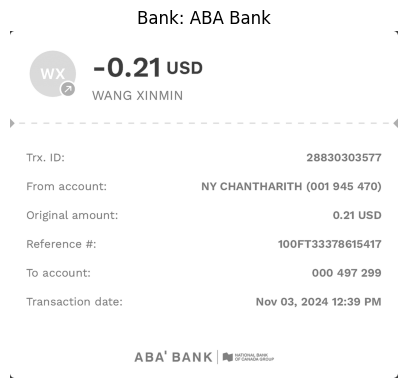

Extracted Transaction Data:
"4 >\n+. =Q.217 usb\n\u17e9 WANG XINMIN\nTrx. ID: 28830303577\nFrom account: NY CHANTHARITH (001 945 470)\nOriginal amount: 0.21 USD\nReference #: 100FT333/78615417\nTo account: 000 497 299\nTransaction date: Nov 03, 2024 12:39 PM\nABA\u2019 BANK | Be sreusees..\n. \u1785"
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted bank: ABA Bank with confidence: 1.00


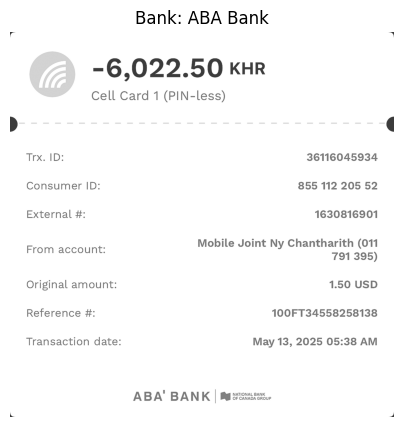

Extracted Transaction Data:
"4 >\n\u17c8 =6,022.50 KHR\n<i Cell Card 1 (PIN-less)\nTrx. ID: 36116045934\nConsumer ID: 855 112 205 52\nExternal #: 1630816901\nFrom account: Mobile Joint Ny Chantharith (011\n, 791 395)\nOriginal amount: 1.50 USD\nReference #: 1OOFT34558258138\nTransaction date: May 13, 2025 05:38 AM\nABA\u2019 BANK | Ba sesusess..\n\u179f\u17c2 \u1780"
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicted bank: ABA Bank with confidence: 1.00


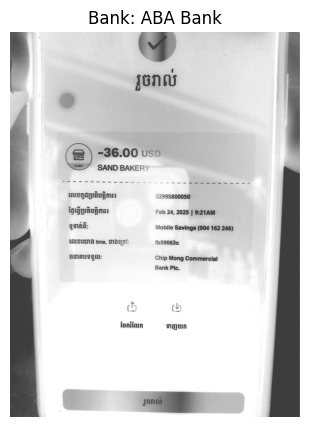

Extracted Transaction Data:
"7 (@ -36.00 Usd \u2018\nq \u201c== SAND BAKERY me\n\u2019 \u179b\u17c1\u1781\u1780\u17bc\u178a\u1794\u17d2\u179a\u178f\u17b7\u1794\u178f\u17d2\u178f\u17b7\u1780\u17b6\u179a\u17d6 32995800050\n\u1790\u17d2\u1784\u17c3\u1792\u17d2\u179c\u17be\u1794\u17d2\u179a\u178f\u17b7\u1794\u178f\u17d2\u178f\u17b7\u1780\u17b6\u179a\u17d6 Feb 24, 2025 | 9:27AM\na. \u1791\u17bc\u1791\u17b6\u178f\u17cb\u1796\u17b8: Mobile Savings (004 162 246)\n\u201d i \u179b\u17c1\u1781\u1799\u17c4\u1784 tmx. \u1781\u17b6\u1784\u1780\u17d2\u179a\u17c5- 59063\u17e0\n4 \u1792\u1793\u17b6\u1782\u17b6\u179a\u1791\u1791\u17bd\u179b: Chip Mong Commercial\na Bank Pic. |\n\u1785\u17c2\u1780\u179a\u17c6\u179b\u17c2\u1780 \u1791\u17b6\u1789\u1799\u1780 .\n: |"
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Predicted bank: ABA Bank with confidence: 1.00


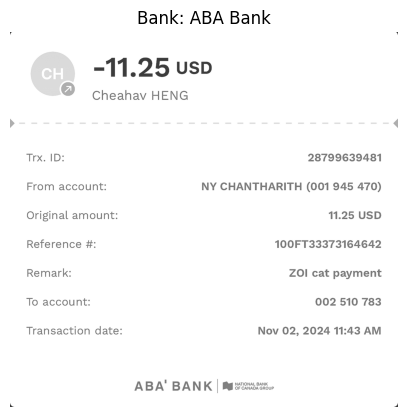

Extracted Transaction Data:
"4 >\n~\u2014@  Cheahav HENG\nTrx. ID: 28799639481\nFrom account: NY CHANTHARITH (001 945 470)\nOriginal amount: 11.25 USD\nReference #: 100FT33373164642\nRemark: ZOlI cat payment\nTo account: 002 510 783\nTransaction date: Nov 02, 2024 11:43 AM\nABA\u2019 BANK | Be ereusees..\n. \u1785"
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted bank: ABA Bank with confidence: 1.00


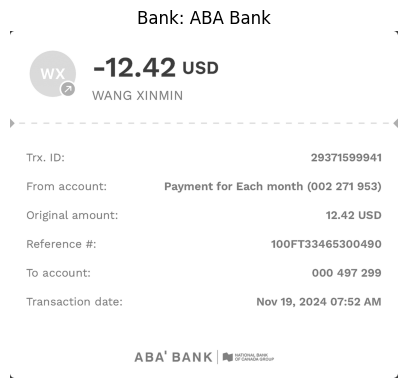

Extracted Transaction Data:
"4 >\n. =12.42 usp\n\u17e9 WANG XINMIN\nTrx. ID: 29371599941\nFrom account: Payment for Each month (002 271 953)\nOriginal amount: 12.42 USD\nReference #: 100FT33465300490\nTo account: 000 497 299\nTransaction date: Nov 19, 2024 07:52 AM\nABA\u2019 BANK | Be sreusees..\n7 \u1785"
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Predicted bank: ABA Bank with confidence: 0.99


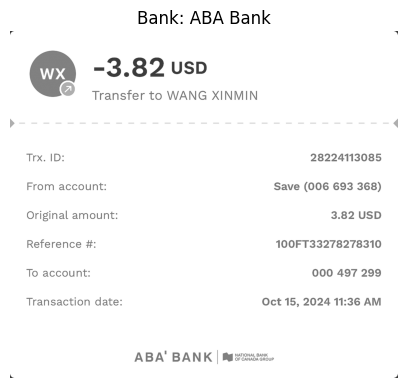

Extracted Transaction Data:
"4 >\n\nWX -3.82 usp\nTransfer to WANG XINMIN\nTrx. ID: 28224113085\nFrom account: Save (006 693 368)\nOriginal amount: 3.82 USD\nReference #: 1OOFT332/782 78310\nTo account: 000 497 299\nTransaction date: Oct 15, 2024 11:36 AM\nABA\u2019 BANK | Be sreusees..\n. \u1785"
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted bank: ABA Bank with confidence: 1.00


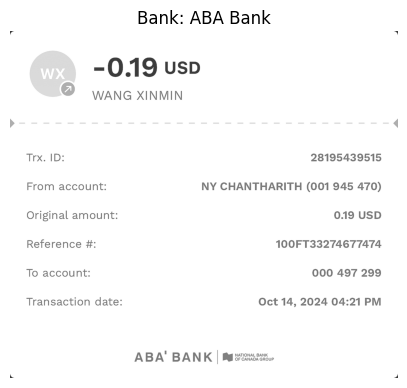

Extracted Transaction Data:
"4 >\n+. =Q.19 usD\n\u17e9 WANG XINMIN\nTrx. ID: 28195439515\nFrom account: NY CHANTHARITH (001 945 470)\nOriginal amount: 0.19 USD\nReference #: 1OOFT332 7467/7474\nTo account: 000 497 299\nTransaction date: Oct 14, 2024 04:21 PM\nABA\u2019 BANK | Be sreusees..\n. \u1785"
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predicted bank: ABA Bank with confidence: 1.00


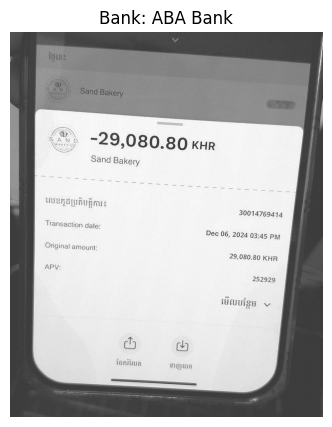

Extracted Transaction Data:
"|\n| \u179a\n\u201c -29,080.80 cur\nSy\nSand Bakery\n\u179b\u17c1\u1781\u1780\u17bc\u178a\u1794\u17d2\u179a\u1780\u17b7\u1794\u178f\u17d2\u178f\u17b7\u1780\u17b6\u179a\u17d6 30014769414\nTransaction date: Dec 06, 2024 03:45 PM\nOriginal amount: 29,080.80 KHR\nAPV: 252929\n\u1798\u17be\u179b\u1794\u1793\u17d2\u1790\u17c2\u1798 +\n\u1780 \u1799\u17b6\n\u1795\u17c2\u1780\u179a\u17c9\u179c\u17c2\u1782 \u1791\u17b6\u1789\u1799\u1782\nSs"
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted bank: ABA Bank with confidence: 0.99


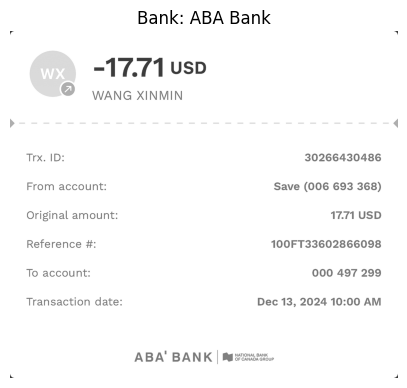

Extracted Transaction Data:
"4 >\n\u17e9 WANG XINMIN\nTrx. ID: 30266430486\nFrom account: Save (006 693 368)\nOriginal amount: 17.71 USD\nReference #: 1OOFT33602866098\nTo account: 000 497 299\nTransaction date: Dec 13, 2024 10:00 AM\nABA\u2019 BANK | Be sreusees..\n. \u1785"
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Predicted bank: ABA Bank with confidence: 1.00


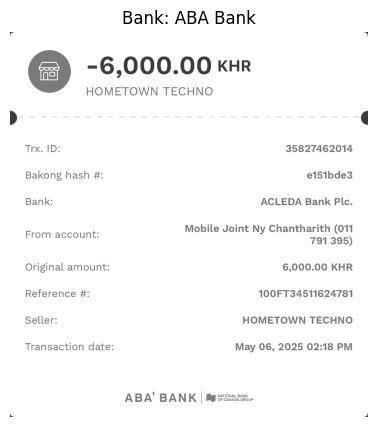

Extracted Transaction Data:
"4 >\n=\u00bb -6,000.00 KHR\n:\nHOMETOWN TECHNO\nTrx. ID: 35827462014\nBakong hash #: e15ibde3\nBank: ACLEDA Bank Plc.\nFrom account: Mobile Joint Ny Chantharith (011\n, 791 395)\nOriginal amount: 6,000.00 KHR\nReference #: 1OOFT34511624781\nSeller: HOMETOWN TECHNO\nTransaction date: May 06, 2025 02:18 PM\nABA\u2019 BANK | Be ereusees..\n\u179f\u17c2 J"


In [41]:
model_path = "../src/backend/models/bank_classification.h5"
model = load_model(model_path)

CLASS_INDEXES = ["ABA Bank", "ACLIDA Bank", "Other"]

folder_path = "../data/raw/Test/"

# Get all image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.png'))]

amount = []

for i, image_file in enumerate(image_files):
    image_path = os.path.join(folder_path, image_file)
    
    classified_image = classify_bank(image_path, model, CLASS_INDEXES)
    
    preprocessed_image = preprocess_image_advanced(image_path)
    if preprocessed_image is None:
        print(f"Skipping {image_file} due to preprocessing error.")
        continue
    
    # Extract data if the bank is classified as "ABA Bank"
    if classified_image == "ABA Bank":
        extracted_all_data = extract_all_text_from_image(image_path)
    #     extracted_data = extract_data_aba(preprocessed_image)
    # else:
    #     extracted_data = {
    #         "transaction_id": "None",
    #         "amount": 0.0,
    #         "date": "None"
    #     }
    
    # Display the preprocessed image
    plt.figure(figsize=(5, 5))
    plt.imshow(preprocessed_image, cmap='gray')
    plt.title(f"Bank: {classified_image}")
    plt.axis('off')
    plt.show()
    
    print(f"Extracted Transaction Data:\n{json.dumps(extracted_all_data, indent=2)}")
    # print(f"Extracted Transaction Data:\n{json.dumps(extracted_data, indent=2)}")
    
#     amount.append(extracted_data['amount'])

# print(f"Total amount: {sum(amount)}")

In [43]:
def extract_data_aba(image, debug=False):
    """
    Extract transaction details from a preprocessed ABA Bank receipt image using hybrid Khmer and English OCR.
    Returns a list of transaction dicts (for compatibility with backend).
    """
    import pytesseract
    import re
    extracted_transactions = []
    try:
        # Use hybrid OCR: Khmer and English
        extracted_text = pytesseract.image_to_string(image, lang='khm+eng')
        lines = [line.strip() for line in extracted_text.splitlines() if line.strip()]
        full_text = "\n".join(lines)

        transaction = {}

        # Extract Trx ID
        for line in lines:
            if "លេខកូដប្រតិបត្តិការ" in line or "លេខកូដ" in line or "Trx. ID" in line or "Transaction ID" in line:
                match = re.search(r'[a-zA-Z0-9]{6,}', line)
                if match:
                    transaction['transaction_id'] = match.group()
                    break

        # Extract Transaction Date
        for line in lines:
            if "ថ្ងៃធ្វើប្រតិបត្តិការ" in line or "Transaction date" in line or "Date" in line:
                match = re.search(r'(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]* \d{1,2}, \d{4} \|? ?\d{1,2}:\d{2}(AM|PM)?', line)
                if match:
                    transaction['date'] = match.group()
                    break

        # Extract Amount (first line with amount)
        for line in lines:
            if re.search(r'-?\d{1,3}(,\d{3})*(\.\d{2})?\s*(KHR|USD|រៀល|ដុល្លារ)', line):
                match = re.search(r'(-?\d{1,3}(,\d{3})*(\.\d{2})?)\s*(KHR|USD|រៀល|ដុល្លារ)', line)
                if match:
                    amount_val = match.group(1).replace(',', '')
                    currency = match.group(4)
                    # Map Khmer currency words to English
                    currency = 'USD' if currency in ['USD', 'ដុល្លារ'] else 'KHR' if currency in ['KHR', 'រៀល'] else currency
                    try:
                        transaction['amount'] = float(amount_val)
                        transaction['currency'] = currency
                    except ValueError:
                        transaction['amount'] = 0.0
                        transaction['currency'] = currency
                    break

        # Optionally extract description
        for line in lines:
            if "Description" in line or "បរិយាយ" in line:
                desc_match = re.search(r'(?:Description|បរិយាយ)[:：]?\s*(.+)', line)
                if desc_match:
                    transaction['description'] = desc_match.group(1).strip()
                    break

        # Only append if transaction_id, amount, and date are present
        if transaction.get('transaction_id') and transaction.get('amount') and transaction.get('date'):
            extracted_transactions.append(transaction.copy())
        else:
            if debug:
                print(f"Could not extract all required fields from ABA statement (OCR text):\n{full_text[:400]}...")

    except pytesseract.TesseractError as e:
        print(f"Tesseract OCR error (ABA): {e}")
    except Exception as e:
        print(f"Error during OCR or extraction (ABA): {e}")
    return extracted_transactions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted bank: ABA Bank with confidence: 1.00


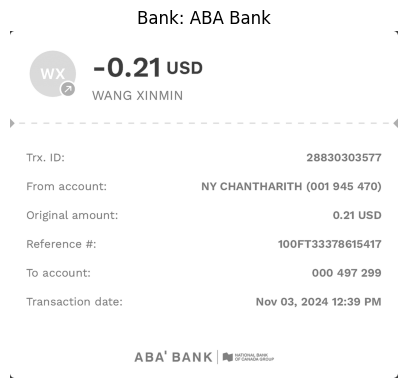

Extracted Transaction Data:
"4 >\n+. =Q.217 usb\n\u17e9 WANG XINMIN\nTrx. ID: 28830303577\nFrom account: NY CHANTHARITH (001 945 470)\nOriginal amount: 0.21 USD\nReference #: 100FT333/78615417\nTo account: 000 497 299\nTransaction date: Nov 03, 2024 12:39 PM\nABA\u2019 BANK | Be sreusees..\n. \u1785"
Extracted Transaction Data:
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Predicted bank: ABA Bank with confidence: 1.00


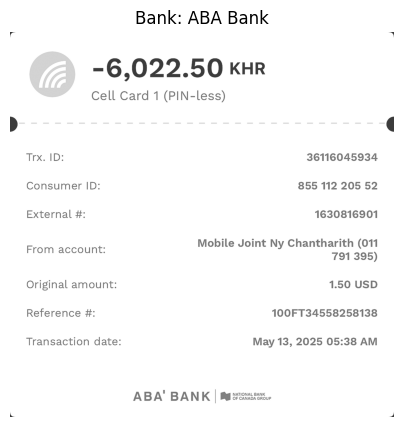

Extracted Transaction Data:
"4 >\n\u17c8 =6,022.50 KHR\n<i Cell Card 1 (PIN-less)\nTrx. ID: 36116045934\nConsumer ID: 855 112 205 52\nExternal #: 1630816901\nFrom account: Mobile Joint Ny Chantharith (011\n, 791 395)\nOriginal amount: 1.50 USD\nReference #: 1OOFT34558258138\nTransaction date: May 13, 2025 05:38 AM\nABA\u2019 BANK | Ba sesusess..\n\u179f\u17c2 \u1780"
Extracted Transaction Data:
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predicted bank: ABA Bank with confidence: 1.00


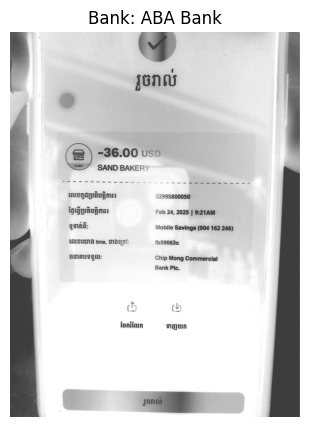

Extracted Transaction Data:
"7 (@ -36.00 Usd \u2018\nq \u201c== SAND BAKERY me\n\u2019 \u179b\u17c1\u1781\u1780\u17bc\u178a\u1794\u17d2\u179a\u178f\u17b7\u1794\u178f\u17d2\u178f\u17b7\u1780\u17b6\u179a\u17d6 32995800050\n\u1790\u17d2\u1784\u17c3\u1792\u17d2\u179c\u17be\u1794\u17d2\u179a\u178f\u17b7\u1794\u178f\u17d2\u178f\u17b7\u1780\u17b6\u179a\u17d6 Feb 24, 2025 | 9:27AM\na. \u1791\u17bc\u1791\u17b6\u178f\u17cb\u1796\u17b8: Mobile Savings (004 162 246)\n\u201d i \u179b\u17c1\u1781\u1799\u17c4\u1784 tmx. \u1781\u17b6\u1784\u1780\u17d2\u179a\u17c5- 59063\u17e0\n4 \u1792\u1793\u17b6\u1782\u17b6\u179a\u1791\u1791\u17bd\u179b: Chip Mong Commercial\na Bank Pic. |\n\u1785\u17c2\u1780\u179a\u17c6\u179b\u17c2\u1780 \u1791\u17b6\u1789\u1799\u1780 .\n: |"
Extracted Transaction Data:
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted bank: ABA Bank with confidence: 1.00


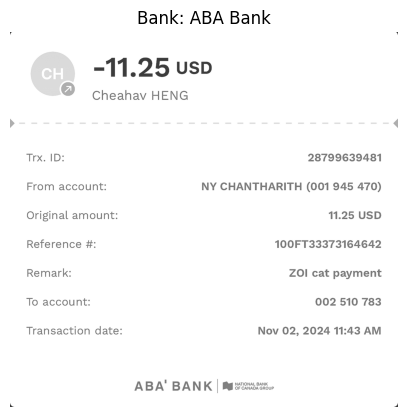

Extracted Transaction Data:
"4 >\n~\u2014@  Cheahav HENG\nTrx. ID: 28799639481\nFrom account: NY CHANTHARITH (001 945 470)\nOriginal amount: 11.25 USD\nReference #: 100FT33373164642\nRemark: ZOlI cat payment\nTo account: 002 510 783\nTransaction date: Nov 02, 2024 11:43 AM\nABA\u2019 BANK | Be ereusees..\n. \u1785"
Extracted Transaction Data:
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicted bank: ABA Bank with confidence: 1.00


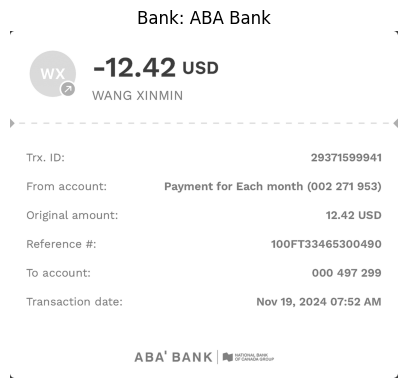

Extracted Transaction Data:
"4 >\n. =12.42 usp\n\u17e9 WANG XINMIN\nTrx. ID: 29371599941\nFrom account: Payment for Each month (002 271 953)\nOriginal amount: 12.42 USD\nReference #: 100FT33465300490\nTo account: 000 497 299\nTransaction date: Nov 19, 2024 07:52 AM\nABA\u2019 BANK | Be sreusees..\n7 \u1785"
Extracted Transaction Data:
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Predicted bank: ABA Bank with confidence: 0.99


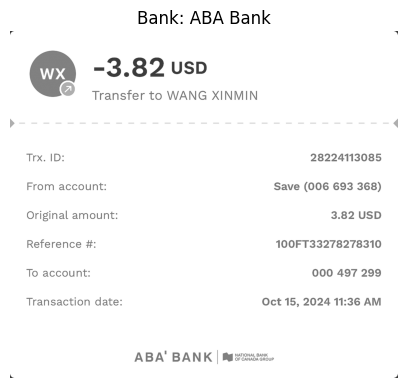

Extracted Transaction Data:
"4 >\n\nWX -3.82 usp\nTransfer to WANG XINMIN\nTrx. ID: 28224113085\nFrom account: Save (006 693 368)\nOriginal amount: 3.82 USD\nReference #: 1OOFT332/782 78310\nTo account: 000 497 299\nTransaction date: Oct 15, 2024 11:36 AM\nABA\u2019 BANK | Be sreusees..\n. \u1785"
Extracted Transaction Data:
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted bank: ABA Bank with confidence: 1.00


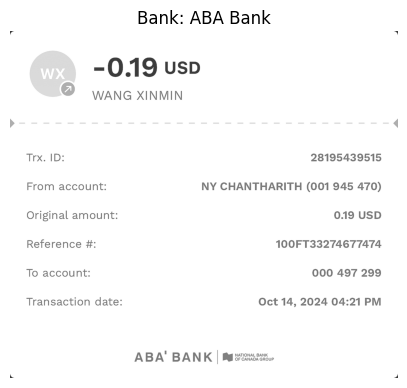

Extracted Transaction Data:
"4 >\n+. =Q.19 usD\n\u17e9 WANG XINMIN\nTrx. ID: 28195439515\nFrom account: NY CHANTHARITH (001 945 470)\nOriginal amount: 0.19 USD\nReference #: 1OOFT332 7467/7474\nTo account: 000 497 299\nTransaction date: Oct 14, 2024 04:21 PM\nABA\u2019 BANK | Be sreusees..\n. \u1785"
Extracted Transaction Data:
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Predicted bank: ABA Bank with confidence: 1.00


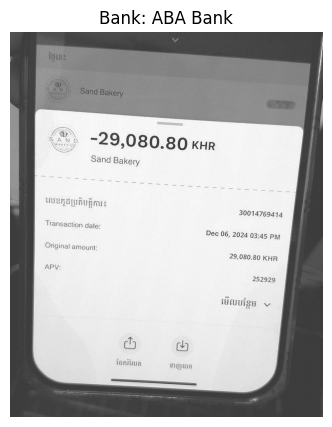

Extracted Transaction Data:
"|\n| \u179a\n\u201c -29,080.80 cur\nSy\nSand Bakery\n\u179b\u17c1\u1781\u1780\u17bc\u178a\u1794\u17d2\u179a\u1780\u17b7\u1794\u178f\u17d2\u178f\u17b7\u1780\u17b6\u179a\u17d6 30014769414\nTransaction date: Dec 06, 2024 03:45 PM\nOriginal amount: 29,080.80 KHR\nAPV: 252929\n\u1798\u17be\u179b\u1794\u1793\u17d2\u1790\u17c2\u1798 +\n\u1780 \u1799\u17b6\n\u1795\u17c2\u1780\u179a\u17c9\u179c\u17c2\u1782 \u1791\u17b6\u1789\u1799\u1782\nSs"
Extracted Transaction Data:
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Predicted bank: ABA Bank with confidence: 0.99


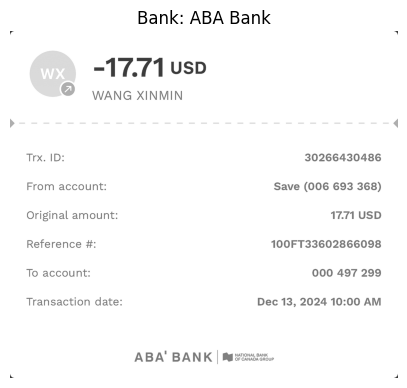

Extracted Transaction Data:
"4 >\n\u17e9 WANG XINMIN\nTrx. ID: 30266430486\nFrom account: Save (006 693 368)\nOriginal amount: 17.71 USD\nReference #: 1OOFT33602866098\nTo account: 000 497 299\nTransaction date: Dec 13, 2024 10:00 AM\nABA\u2019 BANK | Be sreusees..\n. \u1785"
Extracted Transaction Data:
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predicted bank: ABA Bank with confidence: 1.00


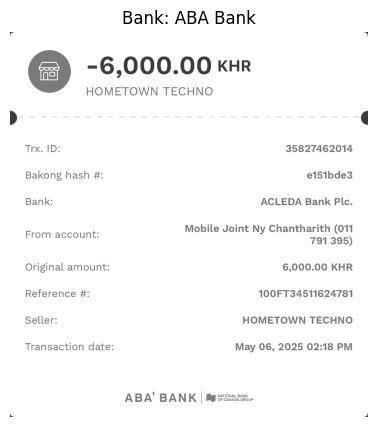

Extracted Transaction Data:
"4 >\n=\u00bb -6,000.00 KHR\n:\nHOMETOWN TECHNO\nTrx. ID: 35827462014\nBakong hash #: e15ibde3\nBank: ACLEDA Bank Plc.\nFrom account: Mobile Joint Ny Chantharith (011\n, 791 395)\nOriginal amount: 6,000.00 KHR\nReference #: 1OOFT34511624781\nSeller: HOMETOWN TECHNO\nTransaction date: May 06, 2025 02:18 PM\nABA\u2019 BANK | Be ereusees..\n\u179f\u17c2 J"
Extracted Transaction Data:
[]


In [45]:
model_path = "../src/backend/models/bank_classification.h5"
model = load_model(model_path)

CLASS_INDEXES = ["ABA Bank", "ACLIDA Bank", "Other"]

folder_path = "../data/raw/Test/"

# Get all image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.png'))]

amount = []

for i, image_file in enumerate(image_files):
    image_path = os.path.join(folder_path, image_file)
    
    classified_image = classify_bank(image_path, model, CLASS_INDEXES)
    
    preprocessed_image = preprocess_image_advanced(image_path)
    if preprocessed_image is None:
        print(f"Skipping {image_file} due to preprocessing error.")
        continue
    
    # Extract data if the bank is classified as "ABA Bank"
    if classified_image == "ABA Bank":
        extracted_all_data = extract_all_text_from_image(image_path)
        extracted_data = extract_data_aba(preprocessed_image)
    else:
        extracted_data = {
            "transaction_id": "None",
            "amount": 0.0,
            "date": "None"
        }
    
    # Display the preprocessed image
    plt.figure(figsize=(5, 5))
    plt.imshow(preprocessed_image, cmap='gray')
    plt.title(f"Bank: {classified_image}")
    plt.axis('off')
    plt.show()
    
    print(f"Extracted Transaction Data:\n{json.dumps(extracted_all_data, indent=2)}")
    print(f"Extracted Transaction Data:\n{json.dumps(extracted_data, indent=2)}")
    
#     amount.append(extracted_data['amount'])

# print(f"Total amount: {sum(amount)}")